In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize, curve_fit
from functools import partial
from tqdm import tqdm


from springlock import GasSpringlock


pd.set_option('display.precision', 3)

In [69]:
# Dimensions to be used for all springlock systems
weapon_mass = 1.5 # kg
weapon_radius = 80 # mm
weapon_arm_length = 300 # mm
weapon_arm_mass = 0.500 # kg
spring_arm_mass = 0.250 # kg

# Target performance
target_weapon_speed = 25 # m/s
max_spring_length = 240 # mm
max_spring_mass = 2 # kg

In [70]:
# Load in the data and set up the model
spring_data = pd.read_csv("springs.csv")


units = {
    'mass_units': 'kg',
    'length_units': 'mm',
    'angle_units': 'deg',
    'pressure_units': 'bar',
    'area_units': 'mm^2',
    'volume_units': 'ml',
    'speed_units': 'm/s',
}

In [71]:
# Create all of the springlocks based off of the data
for i, row in spring_data.iterrows():
    name = f'{row["Manufacturer"]} {row["Model"]}'
    arm_length = row['Stroke'] / 2
    
    initial_length = row['Initial Length']
    final_length = row['Initial Length'] - row['Stroke']
    initial_pressure = row['Initial Pressure']
    initial_force = row['Initial Force']
    final_force = row['Final Force (iso)']

    springlock = GasSpringlock(
        name=name,
        weapon_mass=weapon_mass,
        weapon_radius=weapon_radius,
        weapon_arm_length=weapon_arm_length,
        weapon_arm_mass=weapon_arm_mass,
        spring_arm_length=arm_length,
        spring_arm_mass=spring_arm_mass,
        spring_initial_length=initial_length,
        spring_final_length=final_length,
        spring_initial_pressure=initial_pressure,
        spring_initial_force=initial_force,
        spring_final_force=final_force,
        **units,
    )

    # Save the performance data to the dataframe
    spring_data.loc[i, 'Final Length'] = row['Initial Length'] - row['Stroke']
    spring_data.loc[i, 'Initial Aspect Ratio'] = row['Initial Length'] / row['Diameter']
    spring_data.loc[i, 'Final Aspect Ratio'] = (row['Initial Length'] - row['Stroke']) / row['Diameter']
    spring_data.loc[i, 'Initial Volume'] = springlock.spring_initial_volume
    spring_data.loc[i, 'Final Volume'] = springlock.spring_final_volume
    spring_data.loc[i, 'Max Potential Energy'] = abs(springlock.max_potential_energy)
    spring_data.loc[i, 'Max Torque'] = springlock.max_torque
    spring_data.loc[i, 'Max Radial Force'] = springlock.max_radial_force
    spring_data.loc[i, 'Max Tangential Force'] = springlock.max_tangential_force
    spring_data.loc[i, 'Max Tip Speed'] = springlock.max_tip_speed
    spring_data.loc[i, 'Max Spring Speed'] = springlock.max_spring_speed
    spring_data.loc[i, 'Max Power'] = springlock.max_power
    spring_data.loc[i, 'Tip Speed per Unit Mass'] = springlock.max_tip_speed / row['Mass']
    spring_data.loc[i, 'Energy per Unit Mass'] = abs(springlock.max_potential_energy) / row['Mass']

    stroke_time = row['Stroke'] / (row['Max Speed'] * 1000)
    average_power = -springlock.max_potential_energy / stroke_time
    spring_data.loc[i, 'Average Power'] = average_power

In [84]:
# Find all the suitable springs
options = spring_data[spring_data['Max Tip Speed'] > target_weapon_speed]
options = options[options['Initial Length'] <= max_spring_length]
options = options[options['Max Spring Speed'] <= options['Max Speed']]
options = options[options['Mass'] <= max_spring_mass]

# Sort the options by mass
options.sort_values(by='Max Tip Speed', inplace=True, ascending=False)

print(f'Found {len(options)} suitable springs')
options[['Manufacturer', 'Model', 'Max Tip Speed', 'Tip Speed per Unit Mass', 'Mass', 'Initial Length', 'Stroke', 'Max Radial Force', 'Max Spring Speed']]

Found 13 suitable springs


,Manufacturer,Model,Max Tip Speed,Tip Speed per Unit Mass,Mass,Initial Length,Stroke,Max Radial Force,Max Spring Speed
215,Special Springs,MP3000-032-A,36.877,22.763,1.62,150.0,32.0,45160.0,1.535
112,Special Springs,RV2400-038-B,36.485,21.462,1.70,121.0,38.0,38830.0,1.796
111,Special Springs,RV2400-032-B,33.352,20.716,1.61,109.0,32.0,38180.0,1.384
214,Special Springs,MP3000-025-A,32.220,21.198,1.52,135.0,25.0,42980.0,1.047
204,Special Springs,MP2000-032-A,30.256,29.092,1.04,150.0,32.0,30740.0,1.261
110,Special Springs,RV2400-025-B,29.297,19.531,1.50,95.0,25.0,37160.0,0.951
99,Special Springs,RV1500-038-B,29.117,24.064,1.21,120.0,38.0,24520.0,1.431
213,Special Springs,MP3000-020-A,28.499,19.520,1.46,125.0,20.0,40990.0,0.740
98,Special Springs,RV1500-032-B,26.624,23.354,1.14,108.0,32.0,24140.0,1.103
203,Special Springs,MP2000-025-A,26.416,26.955,0.98,135.0,25.0,29160.0,0.859


In [73]:
# Make some subcatregories for the columns for the different spring types
category_names = [
    'M50-.*', 'M70-.*', 'MP150-.*', 'RV170-.*', 'MP300-.*', 'RV320-.*', 'RV350-.*', 
    'MP500-.*', 'RV500-.*', 'RV750-.*', 'MP1000-.*', 'RV1000-.*', 'RV1200-.*', 
    'RV1500-.*', 'MP2000-.*', 'RV2400-.*', 'MP3000-.*', 'RV4200-.*',]

categories = {name: spring_data[spring_data['Model'].str.contains(name)] for name in category_names}
categories['Others'] = spring_data[~spring_data['Model'].str.contains('|'.join(category_names))]

shapes = ['o', 'x', '+']
color_count = 10

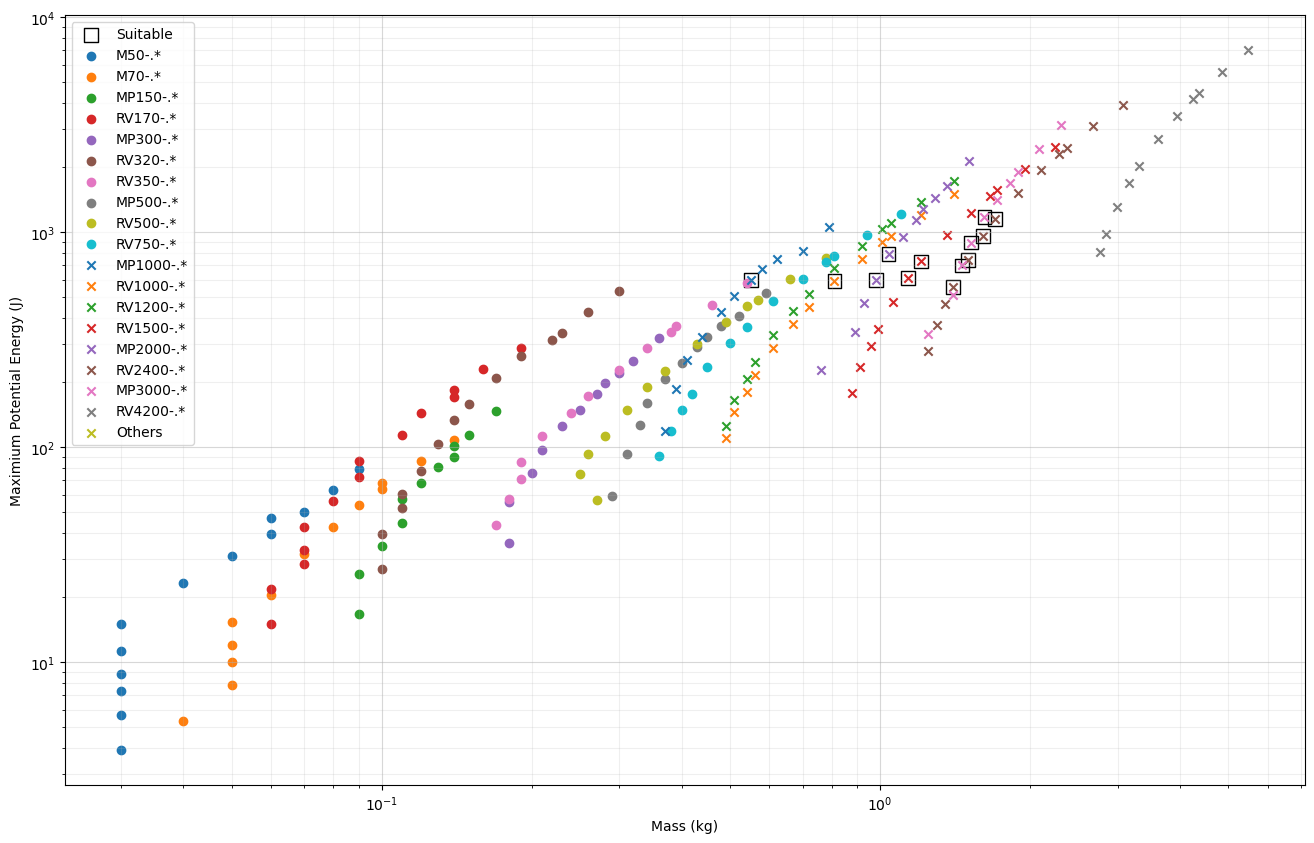

In [74]:
# mass vs potential energy
plt.scatter(options['Mass'], options['Max Potential Energy'], label='Suitable', marker='s', color='black', s=100, facecolors='none')

shape_idx = 0
color_idx = 0
for category_name, category in categories.items():
    plt.scatter(category['Mass'], category['Max Potential Energy'], label=category_name, marker=shapes[shape_idx])
    color_idx += 1
    if color_idx >= color_count:
        color_idx = 0
        shape_idx += 1

        
plt.xlabel('Mass (kg)')
plt.ylabel('Maximium Potential Energy (J)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(16, 10)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.show()


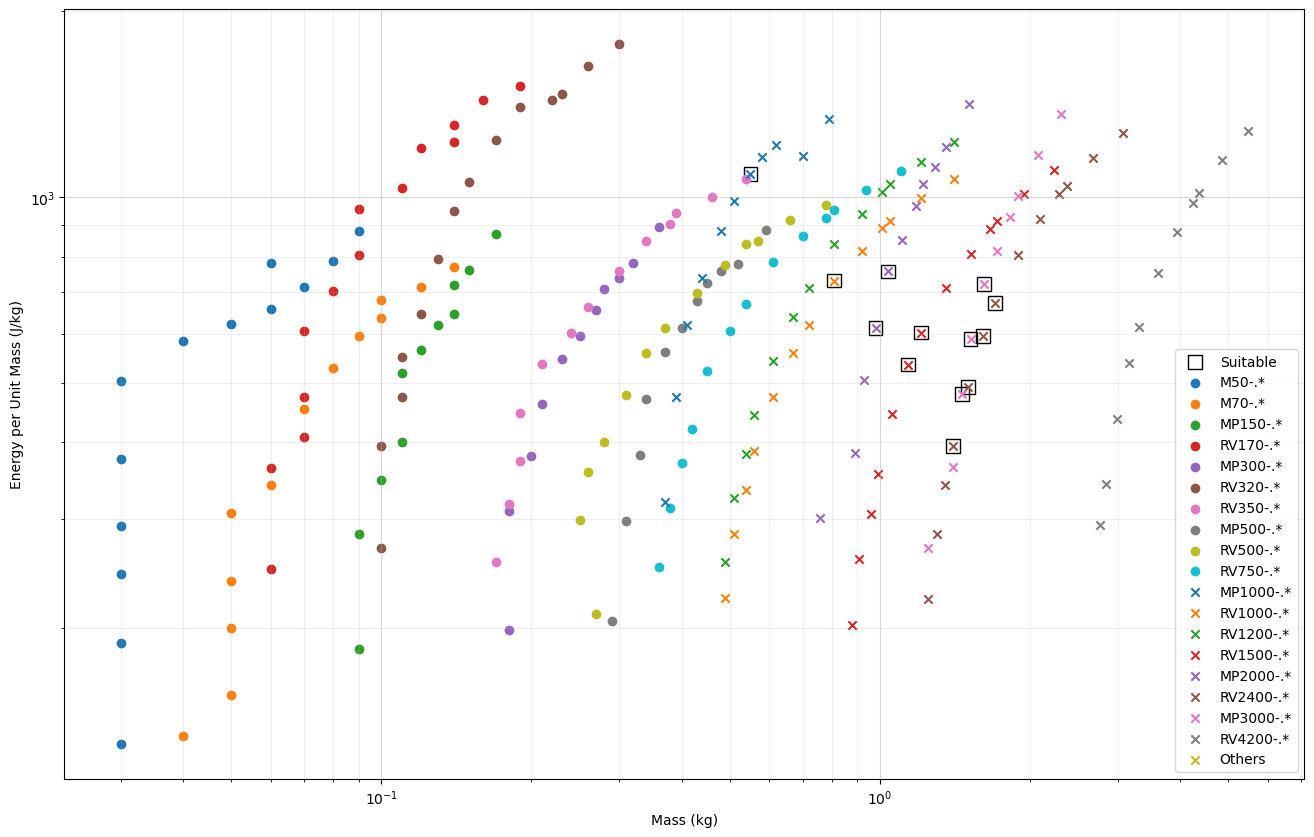

In [75]:
plt.scatter(options['Mass'], options['Energy per Unit Mass'], label='Suitable', marker='s', color='black', s=100, facecolors='none')

color_idx = 0
shape_idx = 0
for category_name, category in categories.items():
    plt.scatter(category['Mass'], category['Energy per Unit Mass'], label=category_name, marker=shapes[shape_idx])
    color_idx += 1
    if color_idx >= color_count:
        color_idx = 0
        shape_idx += 1

plt.xlabel('Mass (kg)')
plt.ylabel('Energy per Unit Mass (J/kg)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(16, 10)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.show()



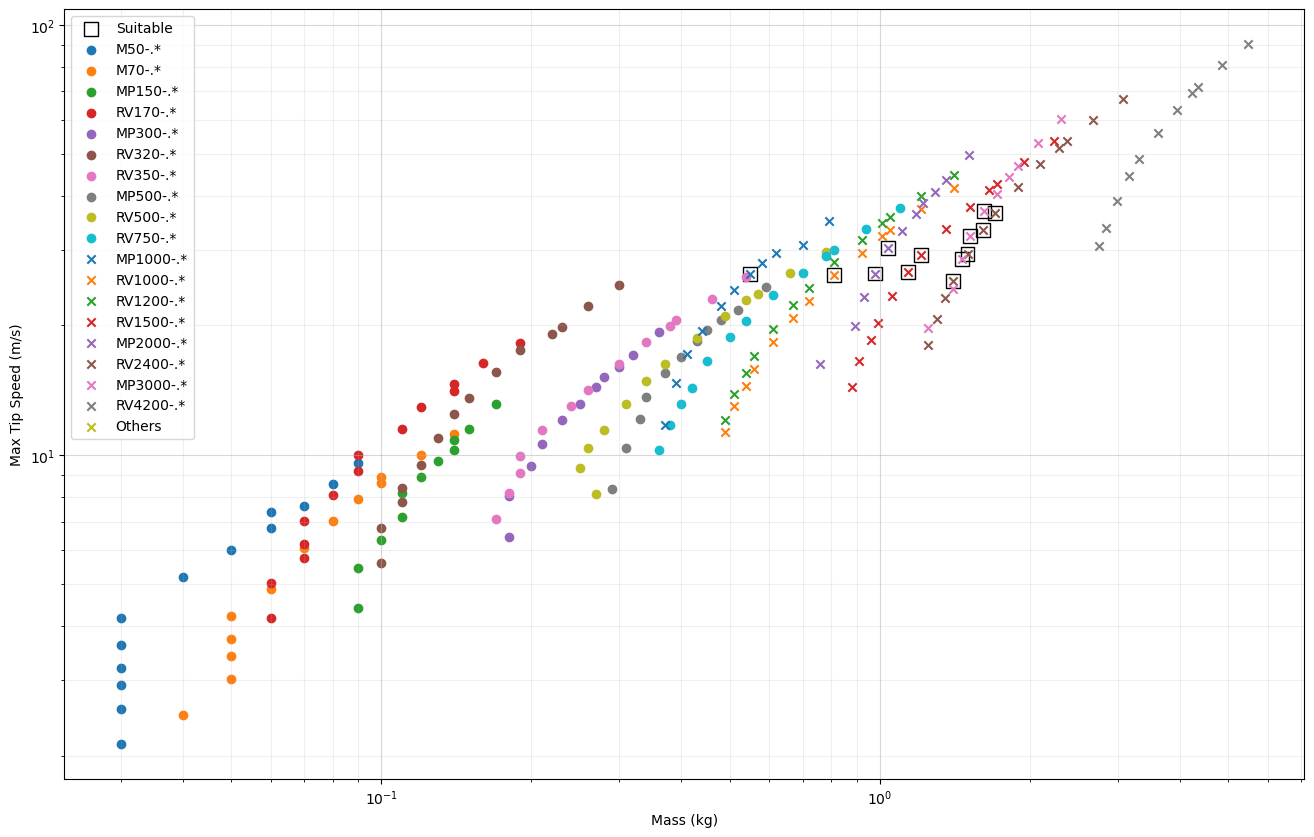

In [76]:
# tip mass vs tip speed
plt.scatter(options['Mass'], options['Max Tip Speed'], label='Suitable', marker='s', color='black', s=100, facecolors='none')

color_idx = 0
shape_idx = 0
for category_name, category in categories.items():
    plt.scatter(category['Mass'], category['Max Tip Speed'], label=category_name, marker=shapes[shape_idx])
    color_idx += 1
    if color_idx >= color_count:
        color_idx = 0
        shape_idx += 1

plt.xlabel('Mass (kg)')
plt.ylabel('Max Tip Speed (m/s)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(16, 10)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.show()

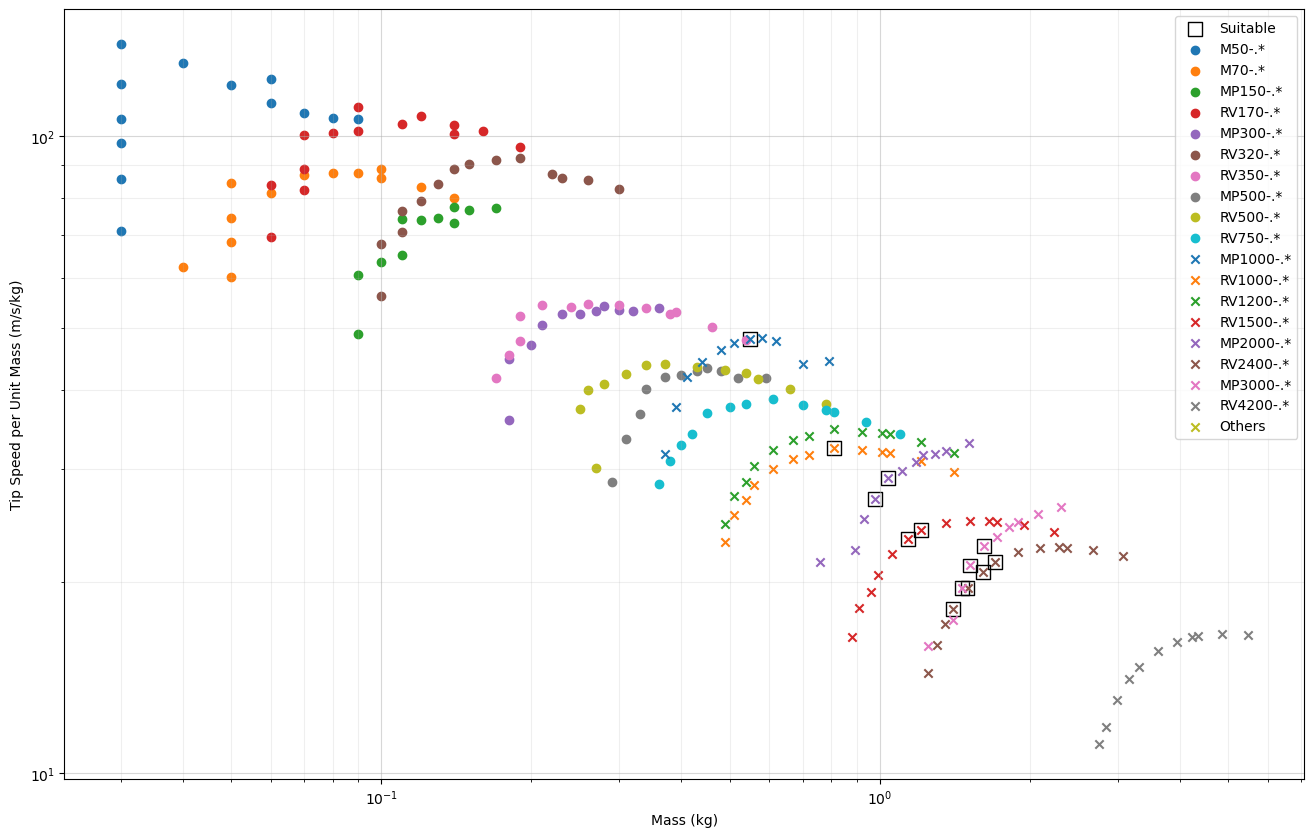

In [77]:
# Max tip speed vs tip speed per unit mass
plt.scatter(options['Mass'], options['Tip Speed per Unit Mass'], label='Suitable', marker='s', color='black', s=100, facecolors='none')

color_idx = 0
shape_idx = 0
for category_name, category in categories.items():
    plt.scatter(category['Mass'], category['Tip Speed per Unit Mass'], label=category_name, marker=shapes[shape_idx])
    color_idx += 1
    if color_idx >= color_count:
        color_idx = 0
        shape_idx += 1

plt.xlabel('Mass (kg)')
plt.ylabel('Tip Speed per Unit Mass (m/s/kg)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(16, 10)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.show()

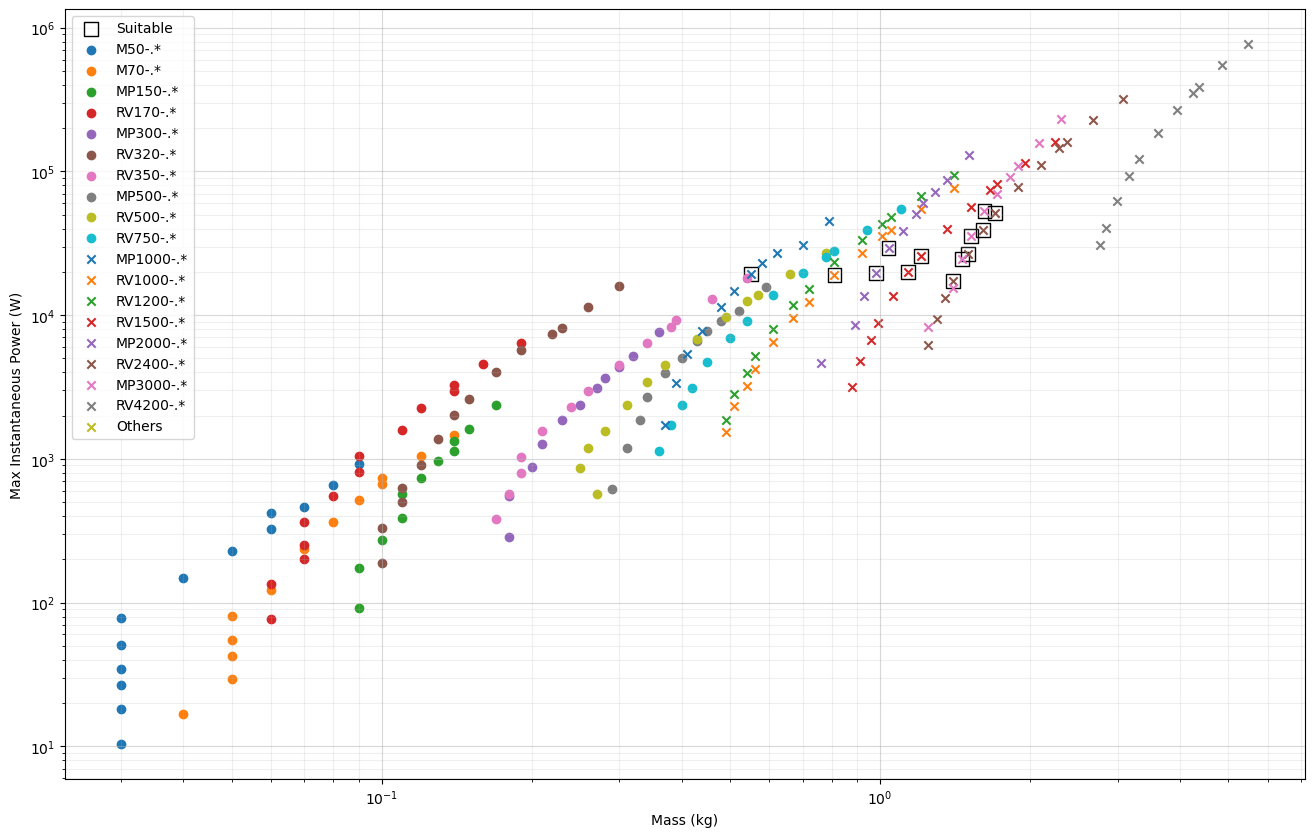

In [78]:
# Mass vs average power
plt.scatter(options['Mass'], options['Max Power'], label='Suitable', marker='s', color='black', s=100, facecolors='none')

color_idx = 0
shape_idx = 0

for category_name, category in categories.items():
    plt.scatter(category['Mass'], category['Max Power'], label=category_name, marker=shapes[shape_idx])
    color_idx += 1
    if color_idx >= color_count:
        color_idx = 0
        shape_idx += 1

plt.xlabel('Mass (kg)')
plt.ylabel('Max Instantaneous Power (W)')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gcf().set_size_inches(16, 10)
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.show()
